# Lab 4

In [1]:
# Import Libraries
import time
import math
import socket
import folium
import requests
# import itertools 
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from pyvis.network import Network
from folium.plugins import MarkerCluster

In [2]:
# Just a function to swap pandas cols
def swap_columns(df, col1, col2):
    col_list = list(df.columns)
    x, y = col_list.index(col1), col_list.index(col2)
    col_list[y], col_list[x] = col_list[x], col_list[y]
    df = df[col_list]
    return df

### Read and Clean Data

In [3]:
FILE = "SFlow_Data_1.csv.csv"
data = pd.read_csv(FILE, delimiter=',',header=None,index_col=False)
# Add header
data.columns = ['Type','sflow_agent_address','inputPort','outputPort'
             ,'src_MAC','dst_MAC','ethernet_type','in_vlan','out_vlan'
             ,'src_IP','dst_IP','IP_protocol','ip_tos','ip_ttl'
             ,'udp_src_port/tcp_src_port/icmp_type','udp_dst_port/tcp_dst_port/icmp_code'
             ,'tcp_flags','packet_size','IP_size','sampling_rate','Unknown_Col']

data.head(1)

Type sflow_agent_address  inputPort  outputPort       src_MAC  \
0  FLOW         aa.aa.aa.aa        137         200  d404ff55fd4d   

        dst_MAC ethernet_type  in_vlan  out_vlan          src_IP  ...  \
0  80711fc76001        0x0800    919.0       280  130.246.176.22  ...   

  IP_protocol  ip_tos ip_ttl  udp_src_port/tcp_src_port/icmp_type  \
0           6    0x00     50                              51216.0   

   udp_dst_port/tcp_dst_port/icmp_code  tcp_flags packet_size  IP_size  \
0                                23505       0x10        1518     1500   

   sampling_rate  Unknown_Col  
0           2048          NaN  

[1 rows x 21 columns]

In [4]:
flowData = data.loc[data['Type'] == 'FLOW']
flowData = flowData.dropna(axis=1,how='all')
flowData.shape

(68065, 20)

In [5]:
cntrData = data.loc[data['Type'] != 'FLOW']
cntrData = cntrData.dropna(axis=1,how='all')
cntrData.shape

(1305, 21)

### EXERCISE 4A: TOP TALKERS AND LISTENERS

#### Top 5 Talkers

Answer may differ due to different IP API.

IP API: https://ipapi.co/

In [6]:
# Get organisation of ip addresses
def getOrg(ipAddress):
    response = requests.get(f'https://ipapi.co/{ipAddress}/json/')
    while response.status_code == 429:
        time.sleep(10)
        response = requests.get(f'https://ipapi.co/{ipAddress}/json/')
        
    return response.json().get("org")

In [7]:
tempData = flowData
topTalkers = tempData['src_IP'].value_counts().to_frame(name="Top 5 Talkers")
topTalkers.reset_index(inplace=True)
topTalkers.columns=['src_IP','Count']
topTalkers=topTalkers.head(5)
topTalkers["Organisation"]= topTalkers['src_IP'].apply(getOrg)
topTalkers = swap_columns(topTalkers,'Count','Organisation')
topTalkers.head()

src_IP                      Organisation  Count
0   193.62.192.8             Jisc Services Limited   3041
1  155.69.160.32  Nanyang Technological University   2975
2  130.14.250.11                            NLM-GW   2604
3  14.139.196.58                  NKN EDGE Network   2452
4  140.112.8.139           Taiwan Academic Network   2056

#### Top 5 Listeners

In [8]:
tempData = flowData
topListeners = tempData['dst_IP'].value_counts().to_frame(name="Top 5 Listeners")
topListeners.reset_index(inplace=True)
topListeners.columns=['dst_IP','Count']
topListeners = topListeners.head(5)
topListeners["Organisation"]= topListeners['dst_IP'].apply(getOrg)
topListeners = swap_columns(topListeners,'Count','Organisation')
topListeners.head()

dst_IP                                    Organisation  Count
0   103.37.198.100                                          A-STAR   3841
1   137.132.228.15                      NUS Information Technology   3715
2   202.21.159.244  Republic Polytechnic. Multihoming AS Singapore   2446
3  192.101.107.153                                        ESNET-AS   2368
4     103.21.126.2                                           Powai   2056

### EXERCISE 4B: TRANSPORT PROTOCOL 

Function to determine TCP/UDP protocol

Source: https://www.iana.org/assignments/service-names-port-numbers/service-names-port-numbers.xhtml

In [9]:
tProtocols = {
    6    : "TCP",
    17   : "UDP" 
}
def prtocolName(protocolNo): 
    if(protocolNo not in tProtocols):
        return "others"
    return tProtocols[protocolNo]

In [10]:
tempData = flowData
protocols = tempData['IP_protocol'].value_counts().to_frame()
protocols.reset_index(inplace=True)
protocols.columns=['Header Value','# of Packet']
protocols['Transport layer protocol'] = protocols['Header Value'].apply(prtocolName)
protocols['%'] = protocols['# of Packet'].apply(lambda x:(x/len(tempData))*100)
# Calculate combined % for other protocols
otherProtocols = protocols.loc[protocols['Transport layer protocol'] == 'others']
otherProtocols = {'Header Value': None, '# of Packet': otherProtocols['# of Packet'].sum()
                 , 'Transport layer protocol': 'others', '%' : otherProtocols['%'].sum()}
protocols = protocols[~protocols["Transport layer protocol"].str.contains("others")]
protocols = pd.concat([protocols,pd.DataFrame([otherProtocols])],ignore_index=True)
protocols = swap_columns(protocols,'# of Packet','Transport layer protocol')
protocols

Header Value Transport layer protocol  # of Packet          %
0            6                      TCP        56064  82.368324
1           17                      UDP         9462  13.901418
2         None                   others         2539   3.730258

### EXERCISE 4C: APPLICATIONS PROTOCOL

Function to determine port service name

Source: https://www.iana.org/assignments/service-names-port-numbers/service-names-port-numbers.xhtml

In [11]:
def portService(port):
    try:
        result = socket.getservbyport(port)
        return result
    except:
        if(port >= 1024 and port <= 49151):
            return "User Ports"
        elif(port >= 49152 and port <= 65535):
            return "Private Ports"
        else:
            return None

In [12]:
tempData = flowData
protocols = tempData['udp_dst_port/tcp_dst_port/icmp_code'].value_counts().to_frame(name="Application Protocol Statistics")
protocols.reset_index(inplace=True)
protocols.columns=['Destination IP port number','# of Packets']
protocols = protocols.head(5)
protocols['Service'] = protocols['Destination IP port number'].apply(portService)
swap_columns(protocols,'# of Packets','Service')

Destination IP port number        Service  # of Packets
0                         443          https         13423
1                          80           http          2647
2                       52866  Private Ports          2068
3                       45512     User Ports          1356
4                       56152  Private Ports          1341

### EXERCISE 4D: TRAFFIC INTENSITY

In [13]:
tempData = flowData
samplingRate = 2048
totalIPSize = tempData['IP_size'].sum() * samplingRate
totalIPSize = totalIPSize / 2**10  / 2**10 # Convert to MB
print("Total calculated sampled traffic (MB): {0:0.2f} MB".format(totalIPSize))

Total calculated sampled traffic (MB): 126519.18 MB


### EXERCISE 4E: ADDITIONAL ANALYSIS

#### 1. Top 5 Communication Pairs

In [14]:
tempData = flowData
pairs = {}
keyFormat = "{ip1} - {ip2}"
for index,row in tempData.iterrows():
    key1 = keyFormat.format(ip1=row['src_IP'],ip2=row['dst_IP'])
    key2 = keyFormat.format(ip1=row['dst_IP'],ip2=row['src_IP'])
    if(key1 in pairs):
        pairs[key1][0] += 1
        pairs[key1][1] += row['IP_size']
        continue
    elif(key2 in pairs):
        pairs[key2][0] += 1
        pairs[key2][1] += row['IP_size']
        continue
    pairs[key1] = [1,row['IP_size']]

# pairs = {k: v for k, v in sorted(pairs.items(), key=lambda item: item[1] , reverse=True)}
# top5pairs = dict(itertools.islice(pairs.items(), 5)) 
# pd.DataFrame(top5pairs.items(), columns = ['Pair', 'Commnuication Count'])
top5pairs = pd.DataFrame([([k] + v) for k, v in pairs.items()], columns=['Src_IP - dst_IP','Comm Count','Total IP Size (MB)'])
print("Top 5 Communcation Pairs sorted by Comm Count")
top5pairs['Total IP Size (MB)'] = top5pairs['Total IP Size (MB)'].apply(lambda x:x/ 2**10  / 2**10)
top5pairs.sort_values(by=['Comm Count'],ascending=False).head(5)

Top 5 Communcation Pairs sorted by Comm Count


Src_IP - dst_IP  Comm Count  Total IP Size (MB)
4       137.132.228.15 - 193.62.192.8        4951            4.141407
139    130.14.250.11 - 103.37.198.100        2842            3.729961
36    14.139.196.58 - 192.101.107.153        2368            0.090342
1184     140.112.8.139 - 103.21.126.2        2056            2.941132
1653     140.90.101.61 - 167.205.52.8        1752            2.119951

In [15]:
print("Top 5 Communcation Pairs sorted by Total IP Size")
top5pairs.sort_values(by=['Total IP Size (MB)'],ascending=False).head(5)

Top 5 Communcation Pairs sorted by Total IP Size


Src_IP - dst_IP  Comm Count  Total IP Size (MB)
4      137.132.228.15 - 193.62.192.8        4951            4.141407
139   130.14.250.11 - 103.37.198.100        2842            3.729961
1184    140.112.8.139 - 103.21.126.2        2056            2.941132
1653    140.90.101.61 - 167.205.52.8        1752            2.119951
9       193.62.192.6 - 202.6.241.101        1385            1.924501

Get IP Geolocation Information

In [16]:
tempData = flowData
ips = list(set(tempData['src_IP'].to_list() + tempData['dst_IP'].to_list()))
main_ips_df = pd.DataFrame()
i = 0
while i < len(ips):
    try:
        res = requests.post("http://ip-api.com/batch",json=ips[i:i+100]).json()
        frames = [main_ips_df,pd.DataFrame(res)]
        main_ips_df = pd.concat(frames)
        i+=100
    except:
        continue
main_ips_df = main_ips_df.rename(columns = {'query':'ip'})

#### 2. Top 20 Countries with Most Users

Data are provided by source http://ip-api.com/. Data may differ from other APIs.

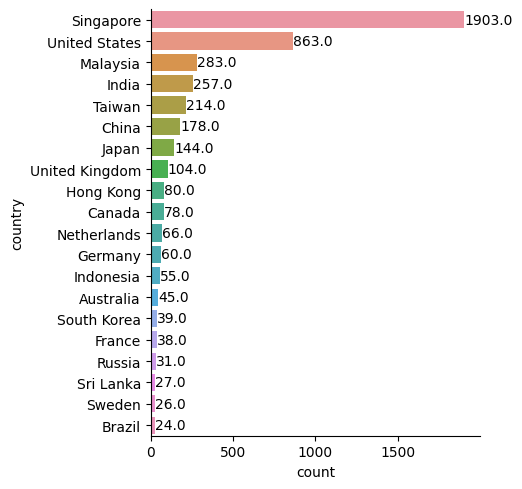

In [17]:
ips_df = main_ips_df
ip_by_country = pd.DataFrame(ips_df.groupby('country').size(), columns=['count'])
ip_by_country.reset_index(inplace=True)
plot = sns.catplot(x='count', y='country', kind="bar" 
                   ,data = ip_by_country.sort_values(by=['count'],ascending=False).head(20)
                   ,orient='h')
ax = plot.facet_axis(0, 0)
for c in ax.containers:
    labels = [f'{v.get_width()}' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge')

#### 3. IP Clusters on World Map and Geolocations

Create Interactive World Map which shows geolocation of all available IP Addresses.
Data are provided by source http://ip-api.com/. Data may differ from other APIs.

Hosting html at: https://raw.githack.com/shinthantaun/CZ3006_Comp_Network_Lab4-/main/ipNetMap.html

In [18]:
ips_df = main_ips_df
ipNetMap = folium.Map(location = [2, 0], zoom_start = 2)
marker_cluster = MarkerCluster().add_to(ipNetMap)
privateip=[] #Save unaccessible IP Address explicitly as 'privateip'
for i in range(0, len(ips_df)):
    try:
        popupText = 'ip:{ip} city:{city}'.format(ip=ips_df.iloc[i]['ip'], city=ips_df.iloc[i]['city'])
        popupText = folium.Popup(popupText, parse_html=True)
        folium.CircleMarker(location = [ips_df.iloc[i]['lat'], ips_df.iloc[i]['lon']],
                            popup=popupText,
                            radius = 6,fill_opacity = 0.9).add_to(marker_cluster)
    except:
        privateip.insert(0,ips_df.iloc[i].tolist())
        continue
ipNetMap.save('ipNetMap.html')
ipNetMap

#### 4. Private or Inaccessible IP Addresses

In [19]:
ips_df = main_ips_df
inaccesibleIPs = pd.DataFrame(privateip, columns=ips_df.columns)
inaccesibleIPs = inaccesibleIPs.rename(columns = {'message':'reason'})
inaccesibleIPs[['ip','reason']]

ip          reason
0              10.202.140.212   private range
1                           -   invalid query
2               10.118.129.86   private range
3                 10.3.31.158   private range
4               10.22.249.189   private range
5                 10.3.83.211   private range
6   fe80::224e:710b:c5cf:1b0f  reserved range
7                    10.3.0.1   private range
8              10.119.244.174   private range
9                10.11.14.202   private range
10                 10.3.32.50   private range
11  fe80::ce4e:24ff:fe9c:6314  reserved range
12                10.11.7.211   private range
13                10.3.83.213   private range
14               10.25.40.229   private range
15             10.119.252.130   private range
16                10.3.70.238   private range
17  fe80::b2a8:6e03:ca76:6716  reserved range
18                 10.1.26.28   private range
19  fe80::72e4:22ff:fe69:fb68  reserved range
20                   10.3.0.2   private range
21                10.25.40.68   private range
22                10.3.31.107   private range
23                 10.3.31.61   private range
24             10.119.237.150   private range
25                10.11.7.214   private range

#### 5. Organization Network Graph

Count Communication Pairs by organisation name only. Else, ignore.

In [20]:
ips_df = main_ips_df
orgPairs = {}

for key,value in pairs.items():
    ippairs = key.split(' - ')
    node1 = ips_df.loc[ips_df['ip'] == ippairs[0]]
    node2 = ips_df.loc[ips_df['ip'] == ippairs[1]]
    
    if(node1.empty or node2.empty):
        continue
    
    node1Org = node2Org = None
    if(node1['org'].item() != '' and not pd.isnull(node1['org'].item())):
        node1Org = node1['org'].item()
    if(node2['org'].item() != '' and not pd.isnull(node2['org'].item())):
        node2Org = node2['org'].item()
    
    if(node1Org is not None and node2Org is not None):
        key1 = (node1['org'].item() , node2['org'].item())
        key2 = (node2['org'].item() , node1['org'].item())
    else:        
        continue
    
    if(key1 in orgPairs):
        orgPairs[key1] += 1
    elif(key2 in orgPairs):
        orgPairs[key2] += 1
    else:
        orgPairs[key1] = 1
orgPairs = {k: v for k, v in sorted(orgPairs.items(), key=lambda item: item[1] , reverse=True)}

Create Interactive Network Graph. Save as html file explcitly since this graph is too heavy to load at Jupyter Notebook.

In [21]:
temp_df = orgPairs
graph2 = nx.Graph()
# threshHold = 2
i=0
for key,value in orgPairs.items():
    node1 = key[0]
    node2 = key[1]
#     if(value <threshHold):
#         continue
    if(node1 == node2):
        continue
    
    if(not graph2.has_node(node1)):
        graph2.add_node(node1)
    elif(not graph2.has_node(node2)):
        graph2.add_node(node2)
    graph2.add_edge(node1, node2, weight=1)        
    
nt = Network(height='1000px', width='100%', bgcolor='#355764', font_color='#81CACF', notebook=True)
nt.from_nx(graph2)
#nt.show_buttons()
nt.save_graph('orgNetwork.html')

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


Hosting html at https://raw.githack.com/shinthantaun/CZ3006_Comp_Network_Lab4-/main/orgNetwork.html

In [22]:
# nt.show('orgNetwork.html')

#### 6. Overall Network Graph

Count Communication Pairs by organisation name if it's avaiable or by IP Address. Else ignore.

In [23]:
ips_df = main_ips_df
OrgIpPairs = {}

for key,value in pairs.items():
    ippairs = key.split(' - ')
    node1 = ips_df.loc[ips_df['ip'] == ippairs[0]]
    node2 = ips_df.loc[ips_df['ip'] == ippairs[1]]
    
    if(node1.empty or node2.empty):
        continue
    
    node1Org = node2Org = None
    if(node1['org'].item() != '' and not pd.isnull(node1['org'].item())):
        node1Org = node1['org'].item()
    if(node2['org'].item() != '' and not pd.isnull(node2['org'].item())):
        node2Org = node2['org'].item()
    
    if(node1Org is not None and node2Org is not None):
        key1 = (node1['org'].item() , node2['org'].item())
        key2 = (node2['org'].item() , node1['org'].item())
    elif(node1Org is None and node2Org is not None):
        key1 = (node1['ip'].item() , node2['org'].item())
        key2 = (node2['org'].item() , node1['ip'].item())
    elif(node1Org is not None and node2Org is None):
        key1 = (node1['org'].item() , node2['ip'].item())
        key2 = (node2['ip'].item() , node1['org'].item())
    else:        
        key1 = (node1['ip'].item() , node2['ip'].item())
        key2 = (node2['ip'].item() , node1['ip'].item())
    
    
    if(key1 in OrgIpPairs):
        OrgIpPairs[key1] += 1
    elif(key2 in OrgIpPairs):
        OrgIpPairs[key2] += 1
    else:
        OrgIpPairs[key1] = 1
        
OrgIpPairs = {k: v for k, v in sorted(OrgIpPairs.items(), key=lambda item: item[1] , reverse=True)}

Create Interactive Network Graph. Save as html file explcitly since this graph is too heavy to load at Jupyter Notebook.

In [24]:
temp_df = OrgIpPairs
graph = nx.Graph()

for key,value in temp_df.items():
    node1 = key[0]
    node2 = key[1]

    if(node1 == node2):
        continue
    
    if(not graph.has_node(node1)):
        graph.add_node(node1)
    elif(not graph.has_node(node2)):
        graph.add_node(node2)
    graph.add_edge(node1, node2, weight=1)        
    
nt = Network(height='1000px', width='100%', bgcolor='#355764', font_color='#81CACF',  notebook=True)
nt.from_nx(graph)
#nt.show_buttons()
nt.save_graph('ipNetwork.html')

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


Hosting html at https://raw.githack.com/shinthantaun/CZ3006_Comp_Network_Lab4-/main/ipNetwork.html